#### Prepared for Gabor's Data Analysis

# Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

# Chapter 17

## Predicting firm exit

In [46]:
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import patsy
import sklearn.metrics as metrics
import statsmodels.formula.api as smf
from plotnine import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    LogisticRegressionCV,
)
from sklearn.metrics import (
    auc,
    brier_score_loss,
    confusion_matrix,
    mean_squared_error,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse

warnings.filterwarnings("ignore")

## Import data 

### Importing and Cleaning Data

We imported the **cleaned dataset** from the preprocessing step, ensuring it was free of missing values and well-structured for analysis. Below are the key **data cleaning and transformation steps** performed before this stage:

#### 📌 Data Cleaning Steps:
- **Dropped variables with excessive missing values** to maintain data integrity.
- **Performed label engineering** to standardize categorical variables.
- **Generated key status indicators:**
  - `alive_status`: Firm's operational status.
  - `default_in_two_years`: Whether the firm defaulted within two years.
- **Replaced negative sales values with 1** to handle data inconsistencies.
- **Created lagged variables for sales** to track historical trends.
- **Generated a new dummy variable for firms with `age = 0`**.
- **Implemented sample design criteria:**
  - Focused on the **cross-section where `year` = 2012 or 2013** and the firm status is alive.
  - **Filtered firms with revenue below €10 million but above €1,000**.
  - Final dataset contains **43,187 observations**.

#### 📌 Feature Engineering:
- **Updated industry category codes** to align with standardized classifications.
- **Enhanced firm characteristics** by creating:
  - `age_squared` (capturing nonlinear age effects).
  - `foreign_management`, `gender`, and `region` indicators.
- **Processed financial variables**:
  - Created **financial ratios** for key performance indicators.
  - **Handled missing or zero asset values** by adding a **flag**.
  - **Generated total assets** and normalized balance sheet & P&L elements by sales.
  - **Winsorized** extreme values to reduce the impact of outliers.
- **Performed imputation** for:
  - **CEO age** (to handle missing values).
  - **Number of employees**, which was a noisy measure.
- **Sales-based transformations**:
  - Computed **sales per million (log & squared)**.
  - Generated **sales change flags and difference variables**.

---

### Creating the Target Variable

Although the **fast-growth target variable** was initially created in the cleaning script, we decided to **drop and redefine it here** for transparency and clarity.  

#### 📌 Target Variable Definition:
- We classify a firm as **"fast-growing"** if its **log sales growth exceeds 20%** (`growth_threshold = log(1.2) ≈ 0.182`).
- This threshold is based on the **OECD definition of high-growth firms**, ensuring comparability with economic research.
- Growth is measured **year-over-year** (rather than over two years) to:
  - Capture **more recent expansion trends**.
  - Maintain **a larger sample size**, avoiding data loss from firm exits or structural changes.
- We use the **winsorized version of sales growth (`d1_sales_mil_log_mod`)** to:
  - Minimize the impact of **extreme outliers** that could distort firm classification.
- Sales were **log-transformed** to:
  - Stabilize variance.
  - Handle **skewed distributions**.
  - Enable a **linear and economically meaningful interpretation** of growth.

#### 📊 Key Insights:
- **12% of firms in our sample are classified as "fast growers".**
- **Firms experiencing rapid expansion** show an **increased likelihood of default**, highlighting potential risks associated with aggressive growth strategies.

In [53]:
# !!! make sure you have run ch17-firm-exit-data-prep.ipynb before
data = pd.read_csv(path + "/firms_clean.csv")
data.drop(columns='fast_growth')

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,flag_miss_ceo_age,ceo_young,labor_avg_mod,flag_miss_labor_avg,default_f,sales_mil_log_sq,flag_low_d1_sales_mil_log,flag_high_d1_sales_mil_log,d1_sales_mil_log_mod,d1_sales_mil_log_mod_sq
0,2012,1.001541e+06,2012-01-01,2012-12-31,481.481476,9.629630e+03,1.303704e+03,0.0,0.000000,0.000000,...,0,1,0.639393,1,no_default,45.190017,0,0,0.000000,0.000000
1,2012,1.002029e+06,2012-01-01,2012-12-31,14929.629883,2.038852e+05,1.204445e+05,0.0,0.000000,0.000000,...,0,1,0.458333,0,no_default,0.016375,0,0,0.000000,0.000000
2,2012,1.003200e+06,2012-01-01,2012-12-31,25.925926,2.222222e+01,1.099630e+04,0.0,0.000000,0.000000,...,1,0,0.639393,1,default,34.614876,0,0,0.000000,0.000000
3,2012,1.011889e+06,2012-01-01,2012-12-31,36625.925781,1.601667e+05,1.891111e+04,0.0,0.000000,0.000000,...,0,0,1.621212,0,no_default,0.698025,0,0,0.000000,0.000000
4,2012,1.014183e+06,2012-01-01,2012-12-31,12551.851562,1.999037e+05,8.274074e+03,0.0,7.407407,7.407407,...,0,0,0.715278,0,no_default,4.171000,0,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37914,2013,4.638406e+11,2013-01-01,2013-12-31,2374.073975,6.485185e+03,2.250741e+04,0.0,0.000000,0.000000,...,0,1,0.639393,1,no_default,17.984252,0,0,-0.484815,0.235046
37915,2013,4.638739e+11,2013-01-01,2013-12-31,244.444443,1.912593e+04,5.674074e+03,0.0,0.000000,0.000000,...,1,0,0.305556,0,default,8.128331,0,0,0.496634,0.246645
37916,2013,4.639820e+11,2013-01-01,2013-12-31,12003.704102,1.091148e+05,1.506185e+05,0.0,0.000000,0.000000,...,0,0,0.506944,0,no_default,0.987503,0,0,0.662642,0.439095
37917,2013,4.640446e+11,2013-01-01,2013-12-31,77248.148438,6.055000e+06,1.930922e+06,0.0,0.000000,0.000000,...,1,0,1.993056,0,no_default,4.649264,0,0,0.012160,0.000148


In [ ]:
# ----------------------------
# 📌 Creating the target variable 
# ----------------------------
# Define the fast growth threshold (20% growth in log terms)
growth_threshold = np.log(1.2)  # ≈ 0.182

# Create the target variable using winsorized log sales growth
data["fast_growth"] = (data["d1_sales_mil_log_mod"] > growth_threshold).astype(int)

# ----------------------------
# 📌 Check Target Distribution
# ----------------------------
print("\n📊 Target Variable Distribution:")
print(data["fast_growth"].value_counts(normalize=True))


📊 Target Variable Distribution:
fast_growth
0    0.873441
1    0.126559
Name: proportion, dtype: float64


In [ ]:
data.describe()

,year,comp_id,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,inc_bef_tax,...,flag_miss_ceo_age,ceo_young,labor_avg_mod,flag_miss_labor_avg,sales_mil_log_sq,flag_low_d1_sales_mil_log,flag_high_d1_sales_mil_log,d1_sales_mil_log_mod,d1_sales_mil_log_mod_sq,fast_growth
count,37919.000000,3.791900e+04,3.791900e+04,3.791900e+04,3.791900e+04,3.791900e+04,3.791900e+04,3.791900e+04,3.791900e+04,3.791900e+04,...,37919.000000,37919.000000,37919.000000,37919.000000,3.791900e+04,37919.000000,37919.000000,37919.000000,37919.000000,37919.000000
mean,2012.497983,1.533930e+11,9.283308e+03,1.003280e+05,8.631877e+04,4.408223e+02,1.614706e+03,1.197270e+03,1.486464e+05,7.067494e+03,...,0.118542,0.269337,0.644089,0.172710,1.208128e+01,0.021625,0.013133,-0.003645,0.155700,0.126559
std,0.500003,1.378109e+11,4.834261e+04,4.317964e+05,4.229631e+05,8.591007e+03,3.132416e+04,3.091674e+04,1.131990e+06,1.205857e+05,...,0.323253,0.443621,1.442493,0.378002,1.039742e+01,0.145458,0.113847,0.394576,0.470027,0.332483
min,2012.000000,1.001541e+06,-1.489630e+04,0.000000e+00,-8.759259e+03,-3.703704e+03,-1.470000e+04,-3.909408e+05,0.000000e+00,-1.091879e+07,...,0.000000,0.000000,0.083333,0.000000,2.074996e-07,0.000000,0.000000,-1.500000,0.000000,0.000000
25%,2012.000000,2.901426e+10,1.148148e+02,3.500000e+03,3.829630e+03,0.000000e+00,0.000000e+00,0.000000e+00,1.851852e+02,-5.770371e+03,...,0.000000,0.000000,0.145833,0.000000,3.893756e+00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2012.000000,1.146923e+11,9.037037e+02,1.208889e+04,1.520741e+04,0.000000e+00,0.000000e+00,0.000000e+00,4.811111e+03,3.740741e+02,...,0.000000,0.000000,0.333333,0.000000,9.619330e+00,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2013.000000,2.568984e+11,4.127778e+03,4.215370e+04,4.916296e+04,0.000000e+00,0.000000e+00,0.000000e+00,4.170185e+04,4.675926e+03,...,0.000000,1.000000,0.639393,0.000000,1.723107e+01,0.000000,0.000000,0.000000,0.031777,0.000000
max,2013.000000,4.641050e+11,3.570863e+06,1.874527e+07,3.660118e+07,1.007889e+06,3.266667e+06,3.253704e+06,1.036673e+08,4.378226e+06,...,1.000000,1.000000,42.118057,1.000000,4.771708e+01,1.000000,1.000000,1.500000,2.250000,1.000000


## Define helper functions

In [ ]:
color = ['blue', 'red', 'green','purple']

def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print("explained_variance: ", round(explained_variance, 4))
    print("r2: ", round(r2, 4))
    print("MAE: ", round(mean_absolute_error, 4))
    print("MSE: ", round(mse, 4))
    print("RMSE: ", round(np.sqrt(mse), 4))


def coef_matrix(X, model):

    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns), pd.DataFrame(np.transpose(model.coef_))], axis=1
    )
    coef_matrix.columns = ["variable", "coefficient"]
    coef_matrix = coef_matrix.append(
        {"variable": "Intercept", "coefficient": model.intercept_},
        ignore_index=True,
    )
    return coef_matrix


def cv_summary(lambdas, C_values, model):
    d = {
        "lambdas": lambdas,
        "C_values": C_values,
        "mean_cv_score": model.scores_[1].mean(axis=0),
    }
    return pd.DataFrame(data=d)


def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({"fpr": fpr, "tpr": tpr, "thresholds": thresholds})

    plot = (
        ggplot(all_coords, aes(x="fpr", y="tpr"))
        + geom_line(color=color[0], size=0.7)
        + geom_area(position="identity", fill="mediumaquamarine", alpha=0.3)
        + xlab("False Positive Rate (1-Specifity)")
        + ylab("True Positive Rate (Sensitivity)")
        + geom_abline(intercept=0, slope=1, linetype="dotted", color="black")
        + scale_y_continuous(limits=(0, 1), breaks=np.arange(0, 1, 0.1), expand=(0, 0.01))
        + scale_x_continuous(limits=(0, 1), breaks=np.arange(0, 1, 0.1), expand=(0.01, 0))
        + theme_bw()
    )
    return plot


def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))


def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold, param_index, :]
    return sigmoid_array(
        np.dot(X, np.transpose(fold_coef)[:-1]) + np.transpose(fold_coef)[-1]
    )


def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy["loss"] = (
        all_coords_copy.false_pos * FP + all_coords_copy.false_neg * FN
    ) / all_coords_copy.n

    t = optimal_threshold
    l = curr_exp_loss

    plot = (
        ggplot(all_coords_copy, aes(x="thresholds", y="loss"))
        + geom_line(color=color[0], size=0.7)
        + scale_x_continuous(breaks=np.arange(0, 1.1, 0.1))
        + coord_cartesian(xlim=(0, 1))
        + geom_vline(xintercept=t, color=color[0])
        + annotate(
            geom="text",
            x=t - 0.01,
            y=max(all_coords_copy.loss) - 0.4,
            label="best threshold: " + str(round(t, 2)),
            colour=color[1],
            angle=90,
            size=7,
        )
        + annotate(geom="text", x=t + 0.06, y=l, label=str(round(l, 2)), size=7)
        + theme_bw()
    )
    return plot


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy["sp"] = 1 - all_coords_copy.true_neg / all_coords_copy.neg
    all_coords_copy["se"] = all_coords_copy.true_pos / all_coords_copy.pos

    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = (
        ggplot(all_coords_copy, aes(x="sp", y="se"))
        + geom_line(color=color[0], size=0.7)
        + scale_y_continuous(breaks=np.arange(0, 1.1, 0.1))
        + scale_x_continuous(breaks=np.arange(0, 1.1, 0.1))
        + geom_point(data=pd.DataFrame({"sp": [sp], "se": [se]}))
        + annotate(
            geom="text",
            x=sp,
            y=se + 0.03,
            label=str(round(sp, 2)) + ", " + str(round(se, 2)),
            size=7,
        )
        + geom_area(position="identity", fill="mediumaquamarine", alpha=0.3)
        + xlab("False Positive Rate (1-Specifity)")
        + ylab("True Positive Rate (Sensitivity)")
        + geom_abline(intercept=0, slope=1, linetype="dotted", color="black")
        + theme_bw()
    )
    return plot


## Check for Data Leakage

In [ ]:
# ----------------------------
# 📌 Check for Data Leakage 🚨
# ----------------------------

# 1️⃣ Check if target variable is in the feature set
target = "fast_growth"
if target in data.columns:
    print(f"⚠️ Warning: Target variable {target} is in the feature set! Potential data leakage!")
else:
    print(f"✅ Target variable {target} is not in the feature set. No immediate data leakage detected.")

# 2️⃣ Check if any features are derived from the target
# Exclude non-numeric columns for correlation analysis
numeric_features = data.select_dtypes(include=[np.number]).columns.tolist()
numeric_features.remove(target)  # Ensure we exclude the target variable

# Compute correlation with target variable
target_corr = data[numeric_features].corrwith(data[target]).abs().sort_values(ascending=False)

# Identify highly correlated features (e.g., correlation > 0.8)
high_corr_features = target_corr[target_corr > 0.8].index.tolist()

if high_corr_features:
    print(f"⚠️ Warning: The following features are highly correlated with {target} (correlation > 0.8):")
    print(high_corr_features)
else:
    print("✅ No features show extreme correlation with the target variable.")

# 3️⃣ Check if any predictors contain sales-related information
sales_related = [col for col in data.columns if "sales" in col.lower()]
if sales_related:
    print(f"⚠️ Warning: The following predictors contain 'sales' and might be problematic for leakage:")
    print(sales_related)
else:
    print("✅ No direct 'sales' features detected.")


⚠️ Warning: Target variable fast_growth is in the feature set! Potential data leakage!
✅ No features show extreme correlation with the target variable.
⚠️ Warning: The following predictors contain 'sales' and might be problematic for leakage:
['sales', 'ln_sales', 'sales_mil', 'sales_mil_log', 'd1_sales_mil_log', 'sales_mil_log_sq', 'flag_low_d1_sales_mil_log', 'flag_high_d1_sales_mil_log', 'd1_sales_mil_log_mod', 'd1_sales_mil_log_mod_sq']

📊 Target Variable Distribution:
fast_growth
0    0.873441
1    0.126559
Name: proportion, dtype: float64


In [58]:
print(data[['sales', 'd1_sales_mil_log_mod']].head())

          sales  d1_sales_mil_log_mod
0  1.203704e+03                   0.0
1  1.136515e+06                   0.0
2  2.785185e+03                   0.0
3  4.336667e+05                   0.0
4  1.297296e+05                   0.0


### Correlation and Multicollinearity Check

There are many highly correlated variables in the dataset, but upon closer examination, most of these features are either **directly derived from each other** through feature engineering (e.g., binary variables, squared terms, and log transformations) or **conceptually related** (e.g., different representations of the same financial metric). Many correlations arise from **mathematical relationships**, such as `age` and `age²` or `sales` and `log(sales)`, while others come from **categorical encodings and flags** that capture similar information. Despite the high correlations, the Variance Inflation Factor (VIF) analysis did not identify multicollinearity issues, likely because the relationships do not create redundancy in the model.

In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ----------------------------
# 📌 Identify Categorical Variables 🏷️
# ----------------------------
categorical_vars = data.select_dtypes(include=['object', 'category']).columns.to_list()

# 🛠️ Manually add 'begin' and 'end' (since they are causing issues)
categorical_vars.extend(['begin', 'end'])

# ----------------------------
# 📌 Drop Categorical Variables 🗑️
# ----------------------------
df_filtered = data.drop(columns=categorical_vars)

# ----------------------------
# 📌 Compute Correlation Matrix 📊
# ----------------------------
corr_matrix = df_filtered.corr()

# ----------------------------
# 📌 Identify Highly Correlated Features 🔍
# ----------------------------
high_corr_pairs = [
    (corr_matrix.index[x], corr_matrix.columns[y]) 
    for x, y in zip(*np.where(np.abs(corr_matrix) > 0.8)) 
    if x < y  # Avoid duplicates
]

# ✅ Print results
print("Highly correlated feature pairs (|correlation| > 0.8):")
print(high_corr_pairs)

# ----------------------------
# 📌 Calculate Variance Inflation Factor (VIF) 📈
# ----------------------------
X = df_filtered.drop(columns=[target]).dropna()  # 🛠️ Drop NaNs

# 🚨 Drop constant columns (zero variance)
X = X.loc[:, X.nunique() > 1]

# ✅ Compute VIF for each feature
vif_data = pd.DataFrame({
    'Feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# ----------------------------
# 📌 Print VIF Results 📢
# ----------------------------
print("\nVariance Inflation Factor (VIF):")
print(vif_data.sort_values(by="VIF", ascending=False))  # 🏆 Sort for better readability

Highly correlated feature pairs (|correlation| > 0.8):
[('year', 'new'), ('extra_inc', 'extra_profit_loss'), ('fixed_assets', 'tang_assets'), ('fixed_assets', 'total_assets_bs'), ('inc_bef_tax', 'profit_loss_year'), ('material_exp', 'sales'), ('material_exp', 'sales_mil'), ('personnel_exp', 'sales'), ('personnel_exp', 'sales_mil'), ('personnel_exp', 'labor_avg_mod'), ('sales', 'sales_mil'), ('tang_assets', 'total_assets_bs'), ('balsheet_length', 'balsheet_notfullyear'), ('founded_year', 'age'), ('founded_year', 'age2'), ('foreign', 'foreign_management'), ('birth_year', 'ceo_age'), ('nace_main', 'ind2'), ('nace_main', 'ind'), ('nace_main', 'ind2_cat'), ('ind2', 'ind'), ('ind2', 'ind2_cat'), ('ind', 'ind2_cat'), ('ln_sales', 'sales_mil_log'), ('ln_sales', 'sales_mil_log_sq'), ('sales_mil_log', 'sales_mil_log_sq'), ('d1_sales_mil_log', 'd1_sales_mil_log_mod'), ('age', 'age2'), ('extra_inc_pl', 'extra_profit_loss_pl'), ('extra_inc_pl', 'extra_profit_loss_pl_quad'), ('inc_bef_tax_pl', 'prof

## Model building

### Define variable sets 

 Main firm variables

In [ ]:
rawvars = [
    "curr_assets",
    "curr_liab",
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "fixed_assets",
    "inc_bef_tax",
    "intang_assets",
    "inventories",
    "liq_assets",
    "material_exp",
    "personnel_exp",
    "profit_loss_year",
    #"sales",
    "share_eq",
    "subscribed_cap",
]

Further financial variables

In [ ]:
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]
engvar = [
    "total_assets_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "share_eq_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
    "extra_exp_pl",
    "extra_inc_pl",
    "extra_profit_loss_pl",
    "inc_bef_tax_pl",
    "inventories_pl",
    "material_exp_pl",
    "profit_loss_year_pl",
    "personnel_exp_pl",
]
engvar2 = [
    "extra_profit_loss_pl_quad",
    "inc_bef_tax_pl_quad",
    "profit_loss_year_pl_quad",
    "share_eq_bs_quad",
]

 Flag variables

In [ ]:
engvar3 = []
for col in data.columns:
    if (
        col.endswith("flag_low")
        or col.endswith("flag_high")
        or col.endswith("flag_error")
        or col.endswith("flag_zero")
    ):
        engvar3.append(col)

Growth variables - removed due to data leakage, added defaults metric instead 

In [ ]:
# d1 = [
#     "d1_sales_mil_log_mod",
#     "d1_sales_mil_log_mod_sq",
#     "flag_low_d1_sales_mil_log",
#     "flag_high_d1_sales_mil_log",
# ]

d1 = [
    "default",
]

Human capital related variables

In [ ]:
hr = [
    "female",
    "ceo_age",
    "flag_high_ceo_age",
    "flag_low_ceo_age",
    "flag_miss_ceo_age",
    "ceo_count",
    "labor_avg_mod",
    "flag_miss_labor_avg",
    "foreign_management",
]

 Firms history related variables

In [ ]:
firm = ["age", "age2", "new", "C(ind2_cat)", "C(m_region_loc)", "C(urban_m)"]

interactions for logit, LASSO

In [ ]:
interactions1 = [
    "C(ind2_cat)*age",
    "C(ind2_cat)*age2",
    "C(ind2_cat)*ceo_age",
    "C(ind2_cat)*foreign_management",
    "C(ind2_cat)*female",
    "C(ind2_cat)*C(urban_m)",
    "C(ind2_cat)*labor_avg_mod",
]
interactions2 = [
    "profit_loss_year_pl*age",
    "profit_loss_year_pl*female",
    "profit_loss_year_pl*foreign_management",
    "profit_loss_year_pl*fixed_assets_bs",
    "age*foreign_management",
    "age*female",
    "fixed_assets_bs*foreign_management",
    "fixed_assets_bs*female",
]

## Model setups

1. Simple logit models

In [ ]:
target = "fast_growth"

M1 = [
    "profit_loss_year_pl",
    "C(ind2_cat)",
]
M2 = [
    "profit_loss_year_pl",
    "fixed_assets_bs",
    "share_eq_bs",
    "curr_liab_bs ",
    "curr_liab_bs_flag_high ",
    "curr_liab_bs_flag_error",
    "age",
    "foreign_management",
    "C(ind2_cat)",
]
M3 = firm + engvar + d1
M4 = ( firm
    + engvar
    + engvar2
    + engvar3
    + d1
    + hr
    + qualityvars
)
M5 = (firm
    + engvar
    + engvar2
    + engvar3
    + d1
    + hr
    + qualityvars
    + interactions1
    + interactions2
)

2. logit+LASSO

In [ ]:
logit_lasso_vars = (engvar
    + engvar2
    + engvar3
    + d1
    + hr
    + firm
    + qualityvars
    + interactions1
    + interactions2
)

3. CART and RF (no interactions, no modified features)

In [ ]:
rfvars = rawvars + hr + firm + qualityvars

## Quick reminder about probability models

 Linear probability model

In [ ]:
ols_modelx2 = smf.ols("fast_growth~" + "+".join(M2), data).fit(cov_type="HC1")
print(ols_modelx2.summary().as_text())

                            OLS Regression Results                            
Dep. Variable:            fast_growth   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     53.13
Date:                Tue, 04 Mar 2025   Prob (F-statistic):               0.00
Time:                        11:23:50   Log-Likelihood:                -7421.0
No. Observations:               37919   AIC:                         1.512e+04
Df Residuals:                   37780   BIC:                         1.631e+04
Df Model:                         138                                         
Covariance Type:                  HC1                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [ ]:
logit_modelx2 = smf.logit("fast_growth~" + "+".join(M2), data).fit()

Optimization terminated successfully.
         Current function value: 0.373393
         Iterations 7


In [19]:
logit_modelx2 = smf.logit("fast_growth~" + "+".join(M5), data).fit()

         Current function value: 0.244183
         Iterations: 35


In [99]:
print(logit_modelx2.summary())

                           Logit Regression Results                           
Dep. Variable:            fast_growth   No. Observations:                37919
Model:                          Logit   Df Residuals:                    37903
Method:                           MLE   Df Model:                           15
Date:                Sun, 23 Feb 2025   Pseudo R-squ.:                 0.01685
Time:                        20:05:02   Log-Likelihood:                -14159.
converged:                       True   LL-Null:                       -14401.
Covariance Type:            nonrobust   LLR p-value:                 6.929e-94
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.7060      0.083    -20.662      0.000      -1.868      -1.544
C(ind2_cat)[T.27.0]        -0.1482      0.108     -1.373      0.170      -0.360       0.063


With Logit we need to calculate average marginal effects (dy/dx) to be able to interpret the coefficients (under some assumptions...)

In [100]:
print(logit_modelx2.get_margeff().summary())

        Logit Marginal Effects       
Dep. Variable:            fast_growth
Method:                          dydx
At:                           overall
                             dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
C(ind2_cat)[T.27.0]        -0.0162      0.012     -1.373      0.170      -0.039       0.007
C(ind2_cat)[T.28.0]        -0.0077      0.009     -0.874      0.382      -0.025       0.010
C(ind2_cat)[T.29.0]         0.0044      0.015      0.285      0.775      -0.026       0.034
C(ind2_cat)[T.30.0]         0.0215      0.018      1.173      0.241      -0.014       0.057
C(ind2_cat)[T.33.0]        -0.0080      0.009     -0.913      0.361      -0.025       0.009
C(ind2_cat)[T.55.0]        -0.0045      0.009     -0.513      0.608      -0.022       0.013
C(ind2_cat)[T.56.0]        -0.0294      0.008     -3.824      0.000      -0.044      -0.014
profit_loss_year_pl 

## 0. Separate train and holdout data

In [101]:
data_train, data_holdout = train_test_split(data, train_size=0.8, random_state=42)

In [102]:
print("Total")
print(data["fast_growth"].value_counts(normalize=True))
print("Train")
print(data_train["fast_growth"].value_counts(normalize=True))
print("Holdout")
print(data_holdout["fast_growth"].value_counts(normalize=True))


Total
fast_growth
0    0.873441
1    0.126559
Name: proportion, dtype: float64
Train
fast_growth
0    0.873809
1    0.126191
Name: proportion, dtype: float64
Holdout
fast_growth
0    0.871967
1    0.128033
Name: proportion, dtype: float64


## 1. Predict probabilities with logit and Lasso with CV

Specify 5 fold cross-validation method

In [103]:
k = KFold(n_splits=5, shuffle=True, random_state=42)

### a) cross validate logit models

Set up X-vars

In [104]:
logit_model_vars = [M1, M2, M3, M4, M5]

Set up Logit model object

No regularisation needed so setting the paremeter to very high value

In [105]:
C_value_logit = [1e20]

In [106]:
logit_models = dict()
CV_RMSE_folds = dict()

for i, model_vars in enumerate(logit_model_vars):

    model_equation = "fast_growth~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_brier = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="neg_brier_score",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    logit_models["M" + str(i + 1)] = LRCV_brier.fit(X_train, y_train)

    # Calculate RMSE on test for each fold
    CV_RMSE_folds["M" + str(i + 1)] = np.sqrt(
        -1 * logit_models["M" + str(i + 1)].scores_[1].ravel()
    )

In [107]:
pd.DataFrame(CV_RMSE_folds)

,M1,M2,M3,M4,M5
0,0.338682,0.338608,0.302766,0.307427,0.299002
1,0.327945,0.327660,0.295242,0.298070,0.293948
2,0.326816,0.326647,0.291840,0.293397,0.292977
3,0.334376,0.334353,0.300860,0.306227,0.300319
4,0.325631,0.325221,0.294327,0.292604,0.291326


### b) Logit + LASSO

In [108]:
model_equation = "fast_growth~" + "+".join(logit_lasso_vars)
y_train, X_train = patsy.dmatrices(model_equation, data_train)

Normalise X vars for Lasso

In [109]:
normalized_logitvars = pd.DataFrame(
    StandardScaler().fit_transform(X_train),
    columns=X_train.design_info.column_names,
)

Set regularization parameters

In [110]:
lambdas = list(10 ** np.arange(-1, -4.01, -1 / 3))
n_obs = normalized_logitvars.shape[0] * 4 / 5
C_values = [
    1 / (l * n_obs) for l in lambdas
]  # Cs are the inverse of regularization strength

Initialize and fit Logit Lasso

In [111]:
logLasso_brier = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="neg_brier_score",
    solver="liblinear",
    random_state=42,
)

logit_models["LASSO"] = logLasso_brier.fit(normalized_logitvars, y_train)

See CV-fold RMSE-s (negative brier score)

In [112]:
cv_summary_lasso = cv_summary(lambdas, C_values, logit_models["LASSO"])
cv_summary_lasso["mean_cv_score"] = np.sqrt(cv_summary_lasso["mean_cv_score"] * -1)
cv_summary_lasso

,lambdas,C_values,mean_cv_score
0,0.100000,0.000412,0.330009
1,0.046416,0.000888,0.305309
2,0.021544,0.001913,0.299197
3,0.010000,0.004121,0.294339
4,0.004642,0.008878,0.291960
5,0.002154,0.019126,0.290719
6,0.001000,0.041207,0.290454
7,0.000464,0.088777,0.290374
8,0.000215,0.191264,0.290427
9,0.000100,0.412065,0.290456


Save best lambda's index for later use

In [113]:
best_lambda_i = cv_summary_lasso["mean_cv_score"].idxmin()

Extract CV test RMSE for the Lasso with best lambda

In [114]:
CV_RMSE_folds["LASSO"] = np.sqrt(
    -1 * logit_models["LASSO"].scores_[1][:, best_lambda_i]
)

## 2.  AUC, Calibration Curve, Confusion Matrix, ROC

0. Calculate AUC for folds


First, for logits

In [115]:
CV_AUC_folds = dict()
for i, model_vars in enumerate(logit_model_vars):

    model_equation = "fast_growth~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_auc = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="roc_auc",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    logit_models["M" + str(i + 1)] = LRCV_auc.fit(X_train, y_train)

    # Calculate AUC on test for each fold
    CV_AUC_folds["M" + str(i + 1)] = logit_models["M" + str(i + 1)].scores_[1].ravel()

For Lasso

In [116]:
logLasso_auc = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="roc_auc",
    solver="liblinear",
    random_state=42,
)
logLasso_auc_fitted = logLasso_auc.fit(normalized_logitvars, y_train)

CV_AUC_folds["LASSO"] = logLasso_auc_fitted.scores_[1][
    :, cv_summary_lasso["mean_cv_score"].idxmin()
]

Put a summary frame together

In [117]:
model_fits = pd.DataFrame(logit_models, index=["Model fit"]).T

summary = (
    model_fits["Model fit"]
    .apply(lambda x: x.n_features_in_)
    .to_frame(name="Number of Coefficients")
)

summary.loc["LASSO", "Number of Coefficients"] = len(
    [i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0]
)

summary["CV RMSE"] = pd.DataFrame(CV_RMSE_folds).T.mean(axis=1)
summary["CV AUC"] = pd.DataFrame(CV_AUC_folds).T.mean(axis=1)

In [118]:
sum(x != 0 for x in model_fits.loc["LASSO"].values[0].coef_[0].tolist())

98

In [119]:
len(
    [i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0]
)

98

In [120]:
summary

,Number of Coefficients,CV RMSE,CV AUC
M1,9,0.330690,0.592583
M2,16,0.330498,0.600141
M3,31,0.297007,0.871998
M4,75,0.299545,0.869751
M5,139,0.295515,0.873172
LASSO,98,0.290348,0.878262


### Take best model and estimate RMSE on holdout  

M4, M5 and LASSO are practically the same - go with the simplest model, M4

In [121]:
best_logit = logit_models["M4"]
model_equation = "fast_growth~" + "+".join(M4)
_, X_holdout = patsy.dmatrices(model_equation, data_holdout)

Best logit holdout RMSE


In [122]:
data_holdout["best_logit_pred_proba"] = best_logit.predict_proba(X_holdout)[:, 1]

round(rmse(data_holdout["best_logit_pred_proba"], data_holdout["fast_growth"]), 3)

0.291

### a) Calibration curve

how well do estimated vs actual event probabilities relate to each other?


In [166]:
create_calibration_plot(
    data_holdout,
    file_name="ch17-figure-1-logit-m4-calibration",
    prob_var="best_logit_pred_proba",
    actual_var="fast_growth",
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
)


NameError: name 'create_calibration_plot' is not defined

### b) Confusion table with different tresholds

Default: the threshold 0.5 is used to convert probabilities to binary classes

Your model is biased toward predicting “No Fast Growth” and misses most actual fast growth cases (recall = 8.8%)! If your goal is to detect fast growth, this model is not reliable yet. You need to improve recall while maintaining a reasonable precision

In [124]:
logit_class_prediction = best_logit.predict(X_holdout)

values, counts = np.unique(logit_class_prediction.tolist(), return_counts=True)
print(values[0], " (not fast growing): ", counts[0])
print(values[1], " (fast growing): ", counts[1])

0.0  (not fast growing):  7428
1.0  (fast growing):  156


Confusion matrix: summarize different type of errors and successfully predicted cases

positive = "yes": explicitly specify the positive case

In [125]:
cm_object1 = confusion_matrix(
    data_holdout["fast_growth"], logit_class_prediction, labels=[0, 1]
)
cm1 = pd.DataFrame(
    cm_object1,
    index=["Actual no fast growth", "Actual fast growth"],
    columns=["Predicted no fast growth", "Predicted fast growth"],
)
cm1

,Predicted no fast growth,Predicted fast growth
Actual no fast growth,6542,71
Actual fast growth,886,85


In [126]:
# we can apply different thresholds

# 0.5 same as before
holdout_prediction = np.where(data_holdout["best_logit_pred_proba"] < 0.5, 0, 1)
cm_object1b = confusion_matrix(
    data_holdout["fast_growth"], holdout_prediction, labels=[0, 1]
)
cm1b = pd.DataFrame(
    cm_object1b,
    index=["Actual no fast growth", "Actual fast growth"],
    columns=["Predicted no fast growth", "Predicted fast growth"],
)
cm1b

,Predicted no fast growth,Predicted fast growth
Actual no fast growth,6542,71
Actual fast growth,886,85


A sensible choice: mean of predicted probabilities

In [127]:
mean_predicted_growth_prob = np.mean(data_holdout["best_logit_pred_proba"])
round(mean_predicted_growth_prob, 3)

0.127

In [128]:
holdout_prediction = np.where(
    data_holdout["best_logit_pred_proba"] < mean_predicted_growth_prob, 0, 1
)
cm_object2 = confusion_matrix(
    data_holdout["fast_growth"], holdout_prediction, labels=[0, 1]
)
cm2 = pd.DataFrame(
    cm_object2,
    index=["Actual no fast growth", "Actual fast growth"],
    columns=["Predicted no fast growth", "Predicted fast growth"],
)
cm2

,Predicted no fast growth,Predicted fast growth
Actual no fast growth,4485,2128
Actual fast growth,22,949


### c) Visualize ROC (with thresholds in steps) on holdout

What if we want to compare multiple thresholds?

First, discrete ROC (with thresholds in steps) on holdout

In [129]:
thresholds = np.arange(0.05, 0.76, 0.05)
#thresholds = sorted(np.geomspace(0.95, 0.05, num=17)) # set these treshold values to get even points in the plot
cm = dict()
true_positive_rates = []
false_positive_rates = []
holdout_prediction = []
for thr in thresholds:
    holdout_prediction = np.where(data_holdout["best_logit_pred_proba"] < thr, 0, 1)
    cm_thr = confusion_matrix(data_holdout["fast_growth"], holdout_prediction, labels=[0, 1])
    cm[thr] = cm_thr
    tn, fp, fn, tp = cm_thr.ravel()
    true_positive_rates.append(tp / (tp + fn))
    false_positive_rates.append(fp / (fp + tn))

In [130]:
tpr_fpr_for_thresholds = pd.DataFrame(
    {
        "thresholds": thresholds,
        "true_positive_rates": true_positive_rates,
        "false_positive_rates": false_positive_rates,
    }
)

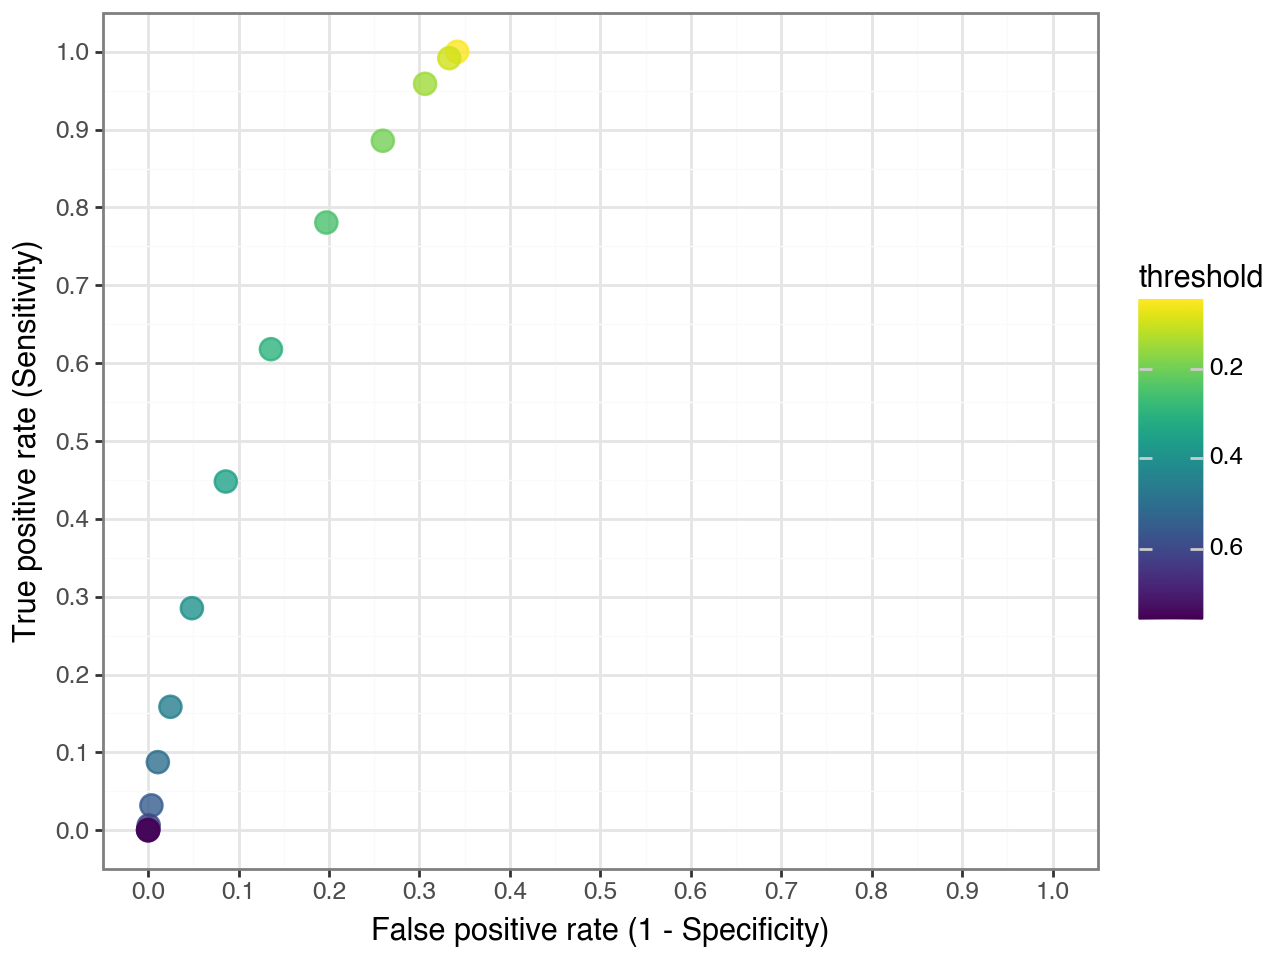

In [131]:
(
    ggplot(
        tpr_fpr_for_thresholds,
        aes(x="false_positive_rates", y="true_positive_rates", color="thresholds"),
    )
    + labs(
        x="False positive rate (1 - Specificity)", y="True positive rate (Sensitivity)"
    )
    + geom_point(size=4, alpha=0.8)
    + scale_color_continuous(trans="reverse", name="threshold")
    + scale_x_continuous(limits=(0, 1), breaks=np.arange(0, 1.01, 0.1))
    + scale_y_continuous(limits=(0, 1), breaks=np.arange(0, 1.01, 0.1))
    + theme_bw()
    + theme(legend_position="right")
)

Continuous ROC on holdout with best model

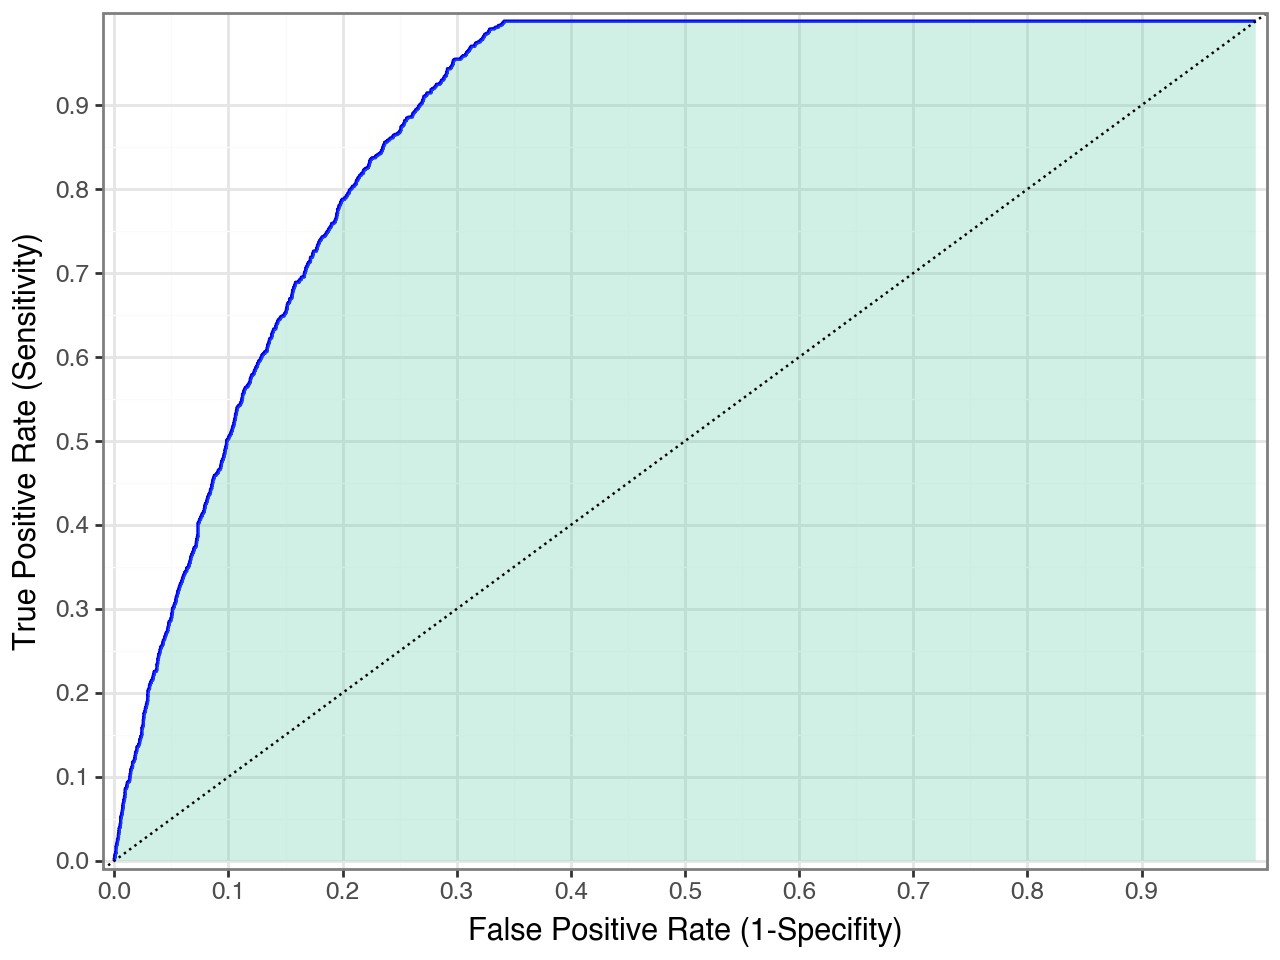

In [171]:
create_roc_plot(data_holdout["fast_growth"], data_holdout["best_logit_pred_proba"])

## 3. We have a loss function

Introduce loss function

Relative cost of of a false negative classification (as compared with a false positive classification)


In [133]:
FP = 1
FN = 10
cost = FN / FP

The prevalence, or the proportion of cases in the population (n.cases/(n.controls+n.cases))


In [134]:
prevelance = y_train.sum() / len(y_train)

Draw ROC Curve and find optimal threshold with loss function 

The optimal cut-off is the threshold that maximizes the distance to the identity (diagonal) line

Iterate through:
 1. models
 2. Folds

In [135]:
best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

for i, model_name in enumerate(logit_models):
    best_thresholds = []
    expected_loss = []

    if model_name != "LASSO":
        _, X = patsy.dmatrices("fast_growth ~" + "+".join(logit_model_vars[i]), data_train)
        X = pd.DataFrame(X)
        c_index = 0
    else:
        X = normalized_logitvars
        c_index = best_lambda_i
    fold = 0
    for train_index, test_index in k.split(X):
        X_fold = X.iloc[test_index, :]
        y_fold = data_train["fast_growth"].iloc[test_index]
        pred_fold = generate_fold_prediction(
            logit_models[model_name], X_fold, fold, c_index
        )
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, pred_fold)
        optimal_threshold = sorted(
            list(
                zip(
                    np.abs(
                        true_pos_rate
                        + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                    ),
                    thresholds,
                )
            ),
            key=lambda i: i[0],
            reverse=True,
        )[0][1]
        best_thresholds.append(optimal_threshold)
        threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)
        tn, fp, fn, tp = confusion_matrix(
            y_fold, threshold_prediction, labels=[0, 1]
        ).ravel()
        curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
        expected_loss.append(curr_exp_loss)
        fold = fold + 1

    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)

    # for fold #5
    fold5_threshold[model_name] = optimal_threshold
    fold5_expected_loss[model_name] = curr_exp_loss

    all_coords = pd.DataFrame(
        {
            "false_pos": false_pos_rate * sum(y_fold == 0),
            "true_pos": true_pos_rate * sum(y_fold == 1),
            "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
            "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
            "pos": sum(y_fold == 1),
            "neg": sum(y_fold == 0),
            "n": len(y_fold),
            "thresholds": thresholds,
        }
    )

    fold5_all_coords[model_name] = all_coords

In [136]:
summary_with_lossfnc = pd.DataFrame(
    best_thresholds_cv.items(), columns=["Model", "Avg of optimal thresholds"]
)
summary_with_lossfnc["Threshold for Fold5"] = fold5_threshold.values()
summary_with_lossfnc["Avg expected loss"] = expected_loss_cv.values()
summary_with_lossfnc["Expected loss for Fold5"] = fold5_expected_loss.values()


In [137]:
summary_with_lossfnc

,Model,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,M1,0.097844,0.105275,0.820340,0.826603
1,M2,0.101677,0.111048,0.811769,0.814900
2,M3,0.131759,0.156905,0.298401,0.294874
3,M4,0.102978,0.099067,0.304632,0.297841
4,M5,0.089899,0.089948,0.302884,0.298665
5,LASSO,0.053079,0.107917,0.299885,0.296193


Create loss plot based on Fold5 in CV 

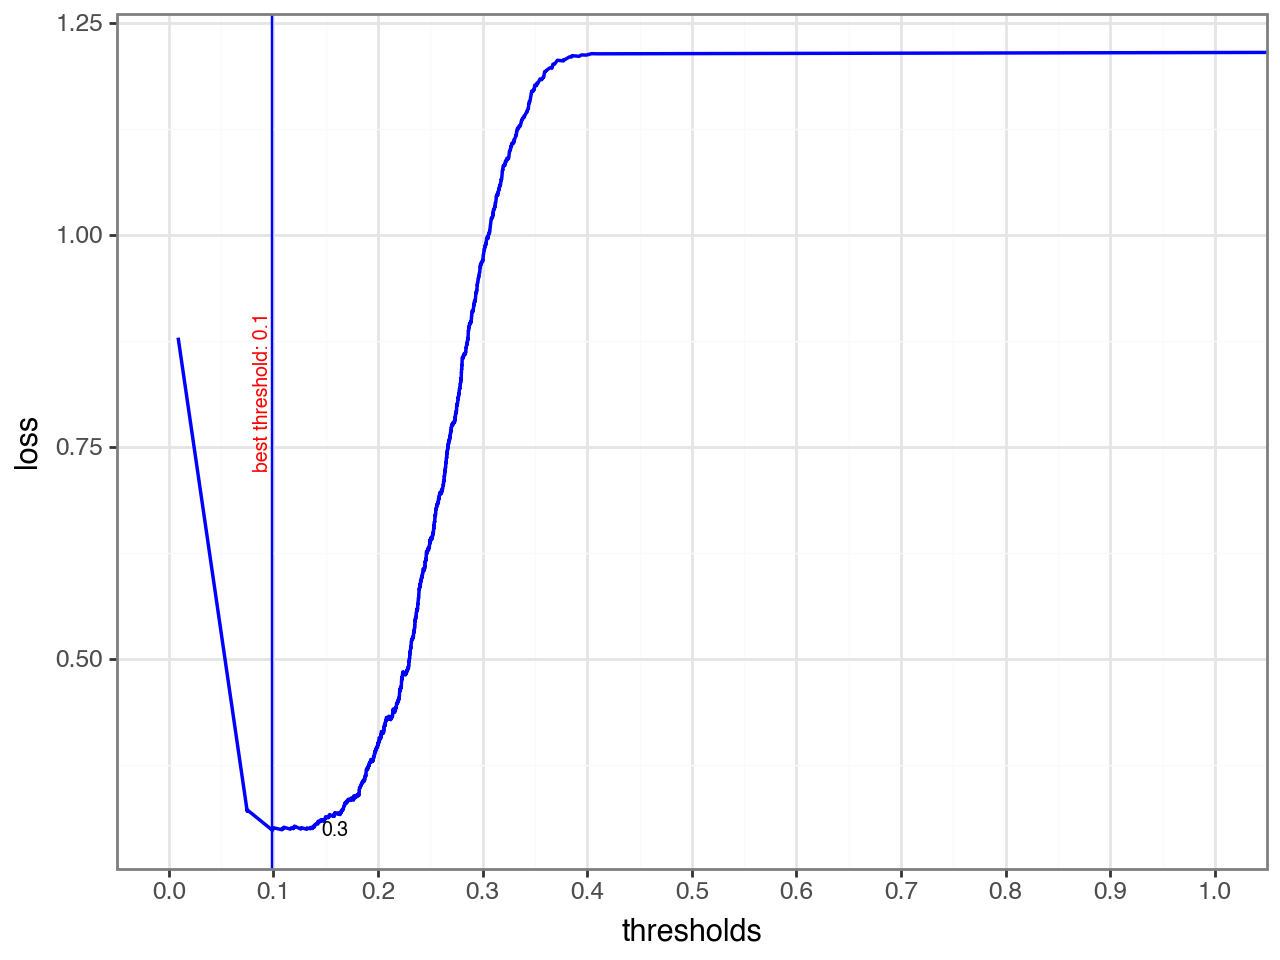

In [177]:
model_to_plot = "M4"  # select model to plot
create_loss_plot(
    fold5_all_coords[model_to_plot],
    fold5_threshold[model_to_plot],
    fold5_expected_loss[model_to_plot],
)

Create roc plot plot based on Fold5 in CV

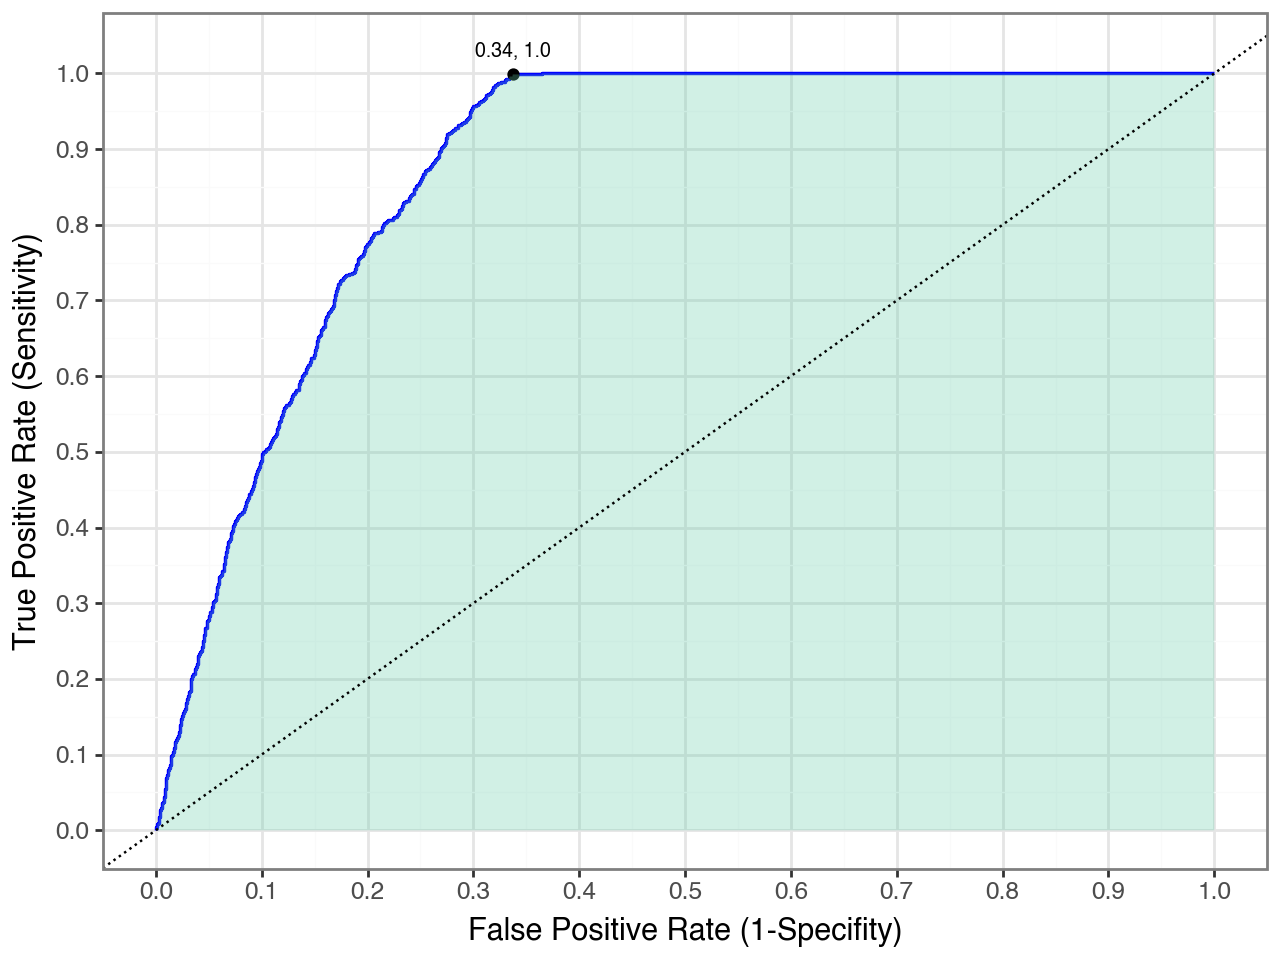

In [178]:
create_roc_plot_with_optimal(
    fold5_all_coords[model_to_plot], fold5_threshold[model_to_plot]
)


Let's see our chosen model, M4's holdout expected loss

In [140]:
best_logit_optimal_treshold = best_thresholds_cv["M4"]

# Get expected loss on holdout
holdout_treshold = np.where(
    data_holdout["best_logit_pred_proba"] < best_logit_optimal_treshold, 0, 1
)
tn, fp, fn, tp = confusion_matrix(
    data_holdout["fast_growth"], holdout_treshold, labels=[0, 1]
).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(data_holdout["fast_growth"])
round(expected_loss_holdout, 3)

0.302

CM on holdout

In [141]:
cm_object3 = confusion_matrix(data_holdout["fast_growth"], holdout_treshold, labels=[0, 1])
cm3 = pd.DataFrame(
    cm_object3,
    index=["Actual no fast growth", "Actual fast growth"],
    columns=["Predicted no fast growth", "Predicted fast growth"],
)
cm3

,Predicted no fast growth,Predicted fast growth
Actual no fast growth,4415,2198
Actual fast growth,9,962


# PREDICTION WITH RANDOM FOREST

In [142]:
y_train, rfvars_train = patsy.dmatrices("fast_growth~" + "+".join(rfvars), data_train)
y_holdout, rfvars_holdout = patsy.dmatrices("fast_growth~" + "+".join(rfvars), data_holdout)

## Graph example for decision tree

<Figure size 640x480 with 0 Axes>

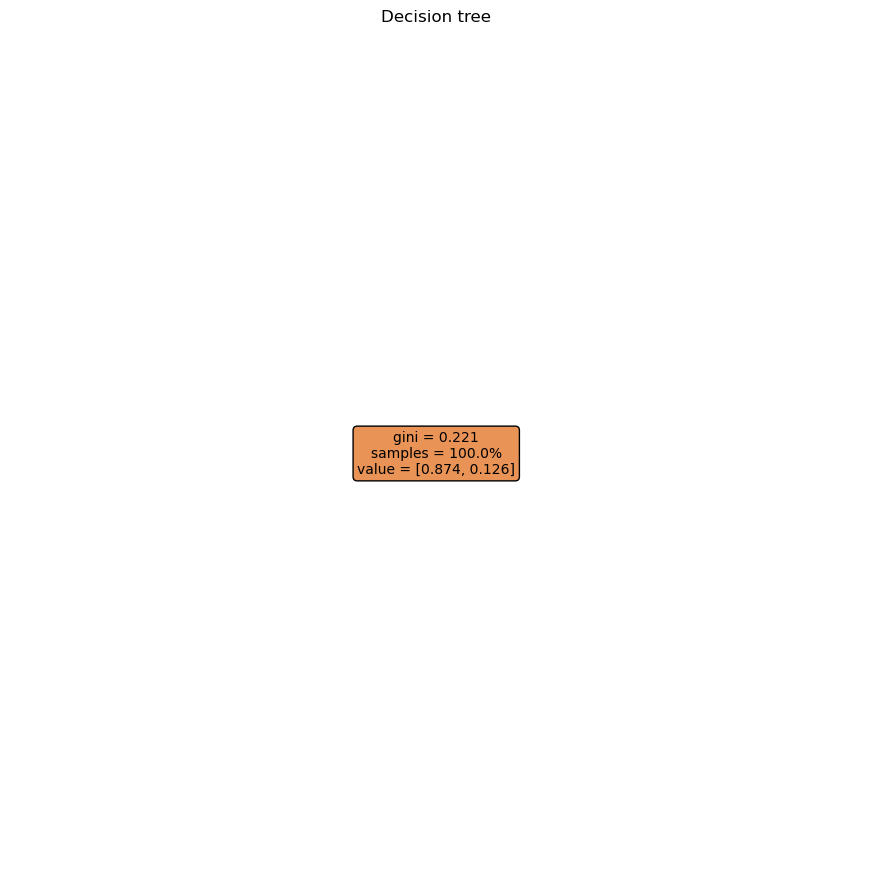

In [143]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

data_for_graph = data_train[[ "profit_loss_year", "foreign_management", #"sales_mil"
                             ]]
rf_for_graph = DecisionTreeClassifier(
    ccp_alpha=0.0028, min_samples_leaf=100, max_depth=3, random_state=41
).fit(data_for_graph, y_train)

plt.figure()
plt.figure(figsize=(11, 11))
plot_tree(
    rf_for_graph,
    feature_names=data_for_graph.columns,
    filled=True,
    rounded=True,
    proportion=True,
    fontsize=10,
)
plt.title("Decision tree")
plt.show()


## Probability forest

Split by gini, ratio of 1's in each tree, average over trees

In [144]:
grid = {
    "max_features": [5, 6, 7],
    "criterion": ["gini"],
    "min_samples_split": [11, 16],
} 

5 fold cross validation

In [145]:
prob_forest = RandomForestClassifier(random_state=42, n_estimators=500, oob_score=True)
prob_forest_grid = GridSearchCV(
    prob_forest,
    grid,
    cv=k,
    refit="roc_auc",
    scoring=["roc_auc", "neg_brier_score"],
)

In [146]:
prob_forest_fit = prob_forest_grid.fit(rfvars_train, y_train)

Create CV summary table

In [147]:
prob_forest_cv_results = pd.DataFrame(
    {
        "max_features": prob_forest_fit.cv_results_["param_max_features"],
        "min_samples_split": prob_forest_fit.cv_results_["param_min_samples_split"],
        "cv_auc": prob_forest_fit.cv_results_["mean_test_roc_auc"],
        "cv_rmse": np.sqrt(
            prob_forest_fit.cv_results_["mean_test_neg_brier_score"] * -1
        ),
    }
)

prob_forest_cv_results

,max_features,min_samples_split,cv_auc,cv_rmse
0,5,11,0.883121,0.287441
1,5,16,0.883446,0.287353
2,6,11,0.883288,0.287337
3,6,16,0.883659,0.287157
4,7,11,0.883274,0.287267
5,7,16,0.883829,0.287113


Obtain optimal parameter values

In [148]:
best_mtry = prob_forest_fit.best_params_["max_features"]
best_min_node_size = prob_forest_fit.best_params_["min_samples_split"]
prob_forest_fit.best_params_


{'criterion': 'gini', 'max_features': 7, 'min_samples_split': 16}

Get average (ie over the folds) RMSE and AUC

In [149]:
prob_forest_best_results = prob_forest_cv_results[
    (prob_forest_cv_results.max_features == best_mtry)
    & (prob_forest_cv_results.min_samples_split == best_min_node_size)
]
prob_forest_best_results_index = prob_forest_best_results.index.values[0]

In [150]:
summary.loc["RF", "Number of Coefficients"] = "n.a."
summary.loc["RF", "CV RMSE"] = prob_forest_best_results["cv_rmse"].values[0]
summary.loc["RF", "CV AUC"] = prob_forest_best_results["cv_auc"].values[0]
summary

,Number of Coefficients,CV RMSE,CV AUC
M1,9.0,0.330690,0.592583
M2,16.0,0.330498,0.600141
M3,31.0,0.297007,0.871998
M4,75.0,0.299545,0.869751
M5,139.0,0.295515,0.873172
LASSO,98.0,0.290348,0.878262
RF,n.a.,0.287113,0.883829


Extract fold level RMSE and AUC

In [151]:
CV_RMSE_folds["RF"] = np.sqrt(
    pd.DataFrame(prob_forest_fit.cv_results_)
    .filter(like="_test_neg_brier_score")
    .loc[lambda x: x["rank_test_neg_brier_score"] == 1]
    .filter(like="split")
    .values[0]
    * -1
)
CV_AUC_folds["RF"] = (
    pd.DataFrame(prob_forest_fit.cv_results_)
    .filter(like="_test_roc_auc")
    .loc[lambda x: x["rank_test_roc_auc"] == 1]
    .filter(like="split")
    .values[0]
)

Take a look at foldwise RMSE and AUC

In [152]:
pd.DataFrame(CV_RMSE_folds)

,M1,M2,M3,M4,M5,LASSO,RF
0,0.338682,0.338608,0.302766,0.307427,0.299002,0.293886,0.290783
1,0.327945,0.327660,0.295242,0.298070,0.293948,0.290570,0.287048
2,0.326816,0.326647,0.291840,0.293397,0.292977,0.287434,0.284499
3,0.334376,0.334353,0.300860,0.306227,0.300319,0.295070,0.291331
4,0.325631,0.325221,0.294327,0.292604,0.291326,0.284781,0.281788


In [153]:
pd.DataFrame(CV_AUC_folds)

,M1,M2,M3,M4,M5,LASSO,RF
0,0.597311,0.600985,0.878251,0.865636,0.878178,0.883310,0.887644
1,0.590598,0.595940,0.871791,0.873316,0.871114,0.872677,0.880036
2,0.588190,0.594032,0.869112,0.869898,0.871594,0.878256,0.883313
3,0.598202,0.607358,0.868975,0.864181,0.868990,0.874124,0.878399
4,0.588617,0.602388,0.871861,0.875724,0.875985,0.882941,0.889753


Now use loss function and search for best thresholds and expected loss over folds 

In [154]:
best_thresholds = list()
expected_loss = list()
rfvars_train = pd.DataFrame(rfvars_train)

fold = 0
for train_index, test_index in k.split(rfvars_train):
    X_fold = rfvars_train.iloc[test_index, :]
    y_fold = data_train["fast_growth"].iloc[test_index]

    X_fold_train = rfvars_train.iloc[train_index, :]
    y_fold_train = data_train["fast_growth"].iloc[train_index]

    prob_forest_best = RandomForestClassifier(
        random_state=42,
        n_estimators=500,
        oob_score=True,
        criterion="gini",
        max_features=best_mtry,
        min_samples_split=best_min_node_size,
    )
    prob_forest_best_fold = prob_forest_best.fit(X_fold_train, y_fold_train)
    pred_fold = prob_forest_best_fold.predict_proba(X_fold)[:, 1]

    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
    best_threshold = sorted(
        list(
            zip(
                np.abs(
                    true_pos_rate
                    + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                ),
                threshold,
            )
        ),
        key=lambda x: x[0],
        reverse=True,
    )[0][1]
    best_thresholds.append(best_threshold)
    threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(
        y_fold, threshold_prediction, labels=[0, 1]
    ).ravel()
    curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
    expected_loss.append(curr_exp_loss)

fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

all_coords_rf = pd.DataFrame(
    {
        "false_pos": false_pos_rate * sum(y_fold == 0),
        "true_pos": true_pos_rate * sum(y_fold == 1),
        "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
        "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
        "pos": sum(y_fold == 1),
        "neg": sum(y_fold == 0),
        "n": len(y_fold),
        "thresholds": threshold,
    }
)


In [156]:
expected_loss_cv["RF"] = np.mean(expected_loss)
best_thresholds_cv["RF"] = np.mean(best_thresholds)


In [157]:
rf_summary = pd.DataFrame(
    {
        "CV RMSE": [round(prob_forest_best_results["cv_rmse"].values[0], 3)],
        "CV AUC": [round(prob_forest_best_results["cv_auc"].values[0], 3)],
        "Avg of optimal thresholds": [round(best_thresholds_cv["RF"], 3)],
        "Threshold for Fold5": [round(best_threshold, 3)],
        "Avg expected loss": [round(expected_loss_cv["RF"], 3)],
        "Expected loss for Fold5": [round(curr_exp_loss, 3)],
    }
)

rf_summary

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.287,0.884,0.119,0.154,0.298,0.292


Create plots based on Fold5 in CV 

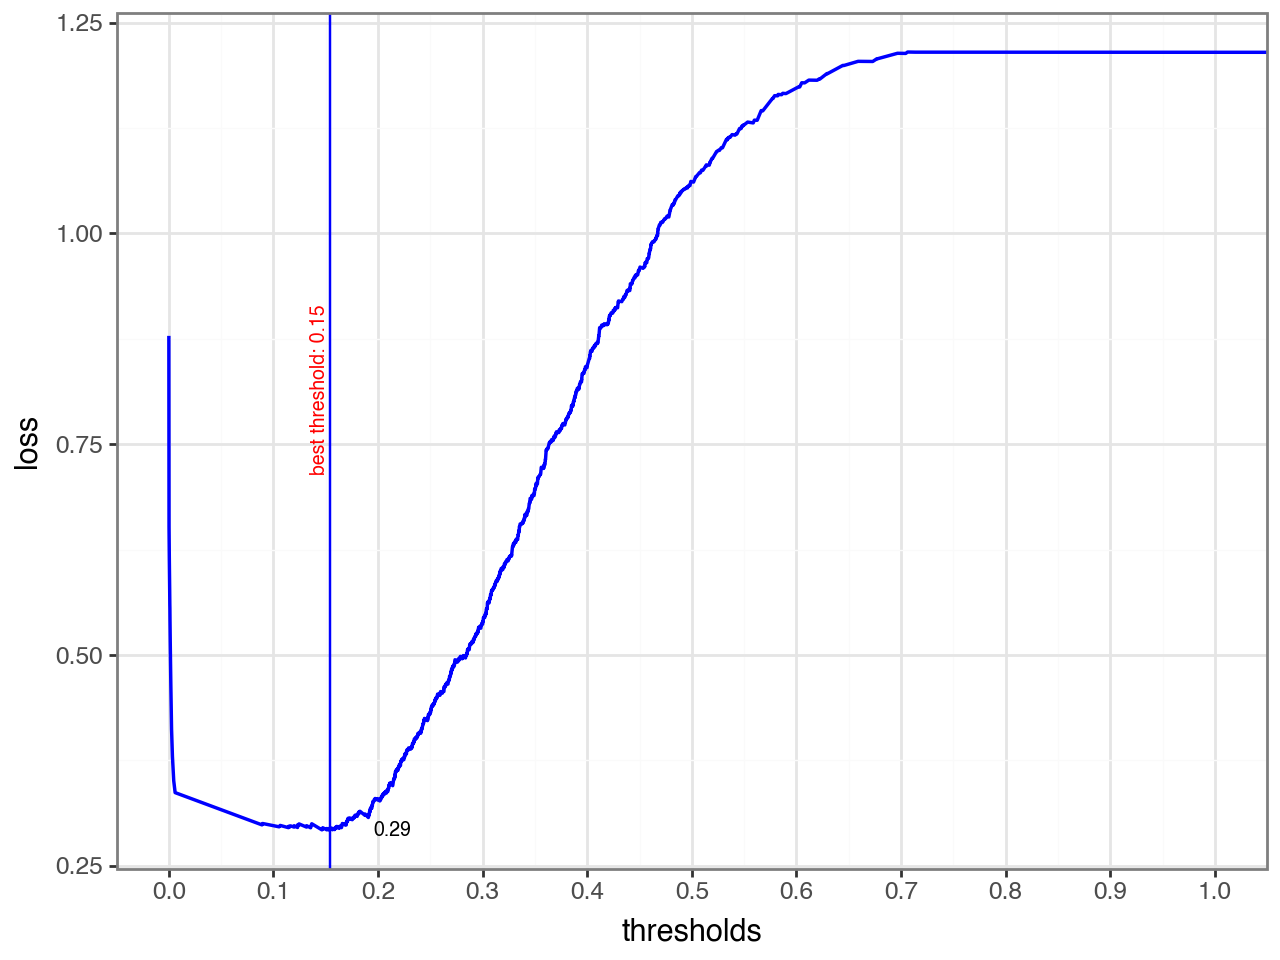

In [179]:
create_loss_plot(all_coords_rf, fold5_threshold_rf, fold5_expected_loss_rf)

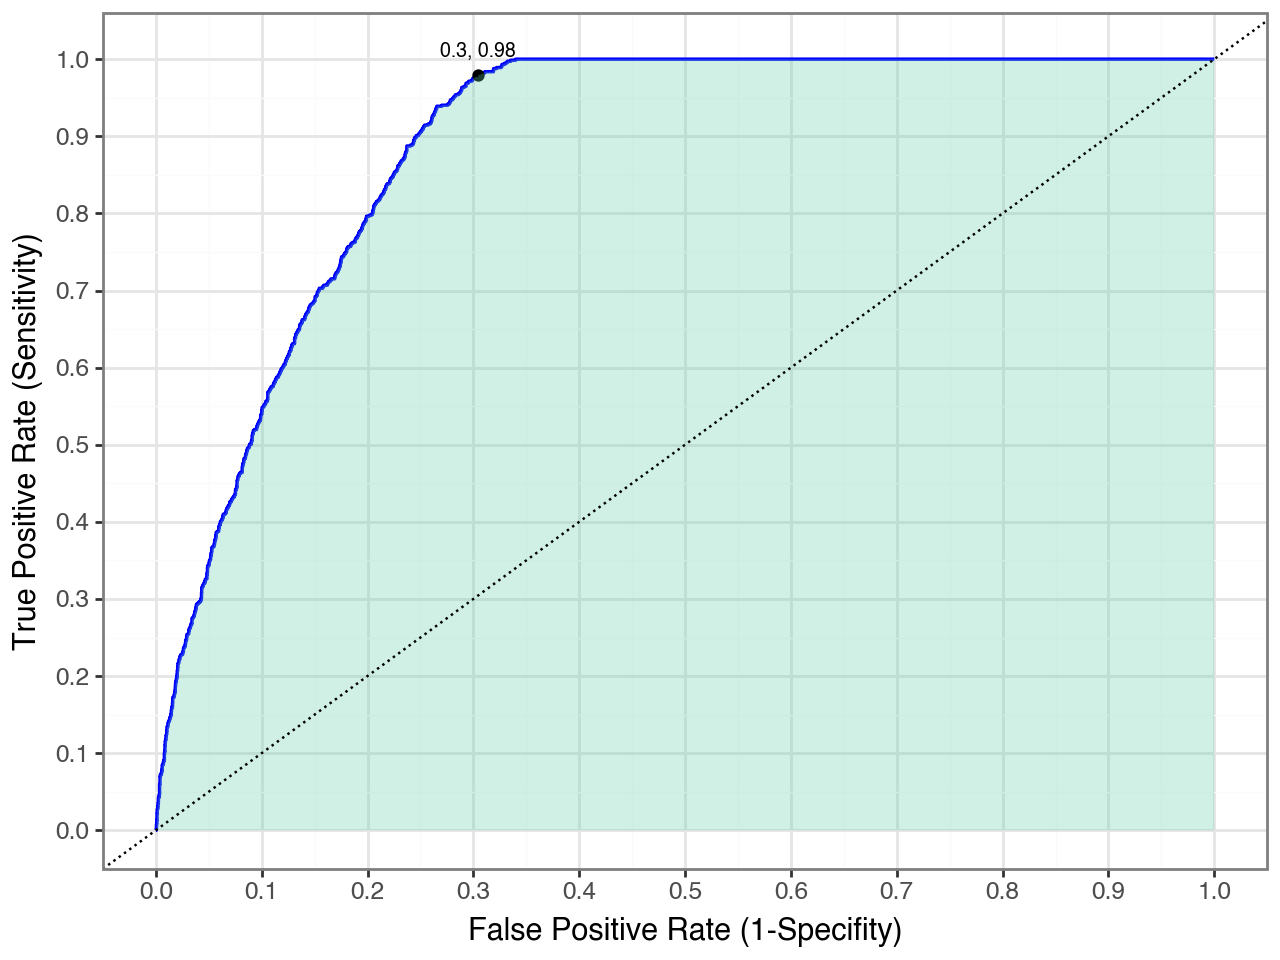

In [180]:
create_roc_plot_with_optimal(all_coords_rf, fold5_threshold_rf)

Take model to holdout and estimate RMSE, AUC and expected loss 

In [160]:
prob_forest_fit_best = prob_forest_fit.best_estimator_
rf_predicted_probabilities_holdout = prob_forest_fit_best.predict_proba(rfvars_holdout)[
    :, 1
]
rmse_rf = np.sqrt(mean_squared_error(y_holdout, rf_predicted_probabilities_holdout))
round(rmse_rf, 3)


0.288

ROC AUC  on holdout

In [161]:
auc_rf = roc_auc_score(y_holdout, rf_predicted_probabilities_holdout)
round(auc_rf, 3)


0.886

 Get expected loss on holdout

In [162]:
holdout_treshold = np.where(
    rf_predicted_probabilities_holdout < best_thresholds_cv["RF"], 0, 1
)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0, 1]).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(y_holdout)
round(expected_loss_holdout, 3)


0.292

## Final results

In [163]:
summary["CV treshold"] = best_thresholds_cv
summary["CV expected Loss"] = expected_loss_cv

In [164]:
summary

,Number of Coefficients,CV RMSE,CV AUC,CV treshold,CV expected Loss
M1,9.0,0.330690,0.592583,0.097844,0.820340
M2,16.0,0.330498,0.600141,0.101677,0.811769
M3,31.0,0.297007,0.871998,0.131759,0.298401
M4,75.0,0.299545,0.869751,0.102978,0.304632
M5,139.0,0.295515,0.873172,0.089899,0.302884
LASSO,98.0,0.290348,0.878262,0.053079,0.299885
RF,n.a.,0.287113,0.883829,0.118564,0.297643
